In [1]:
import numpy as np
import sys, pickle, csv
import cv2

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as VGG19_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as InceptionV3_preprocess
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as ResNet50V2_preprocess
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as Xception_preprocess

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tf_keras_vis.gradcam import Gradcam, GradcamPlusPlus
from tf_keras_vis.scorecam import ScoreCAM
from tf_keras_vis.utils import normalize

%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # memory increase is needed before starting program
        print(e)

In [2]:
# load dataset

image_dim = 512


#dpath_original = 'D:kvasir_cls/kvasir-dataset-v2'
dpath_preprocess = 'D:kvasir_cls'

with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'no_polyp'+'.pickle', 'rb') as f:
    [X,Y] = pickle.load(f)
    print(X.shape, Y.shape)

with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'polyp' + '.pickle', 'rb') as w:
    [X_polyp, Y_polyp] =  pickle.load(w)
    print(X_polyp.shape, Y_polyp.shape)

assert np.max(X) == 255
assert np.min(X) == 0
assert np.max(X_polyp) == 255
assert np.min(X_polyp) == 0

# rest dataset split
X_trnval_no, X_tst_no, Y_trnval_no, Y_tst_no = train_test_split(X, Y, test_size = 1.5 / 10, random_state = 27407, stratify = Y)
X_trn_no, X_val_no, Y_trn_no, Y_val_no = train_test_split(X_trnval_no, Y_trnval_no, test_size = 1.5 / 8.5, random_state = 27407, stratify = Y_trnval_no)

# polyp split
X_trnval_polyp, X_tst_polyp, Y_trnval_polyp, Y_tst_polyp = train_test_split(X_polyp, Y_polyp, test_size = 1.5 / 10, random_state = 27407)
X_trn_polyp, X_val_polyp, Y_trn_polyp, Y_val_polyp = train_test_split(X_trnval_polyp, Y_trnval_polyp, test_size = 1.5 / 8.5, random_state = 27407)

# concatenation and onehot encoding
enc = OneHotEncoder(sparse=False)

X_trn = np.concatenate((X_trn_no, X_trn_polyp), axis=0)
Y_trn = np.concatenate((Y_trn_no, Y_trn_polyp))
Y_trn = enc.fit_transform(Y_trn)

n_class = Y_trn.shape[1]
print("total class number: ", n_class)

X_val = np.concatenate((X_val_no, X_val_polyp), axis=0)
Y_val = np.concatenate((Y_val_no, Y_val_polyp), axis=0)
Y_val = enc.fit_transform(Y_val)

X_tst = np.concatenate((X_tst_no, X_tst_polyp), axis=0)
Y_tst = np.concatenate((Y_tst_no, Y_tst_polyp), axis=0)
Y_tst = enc.fit_transform(Y_tst)


print('trn.shape', X_trn.shape, Y_trn.shape)
print('val.shape', X_val.shape, Y_val.shape)
print('tst.shape', X_tst.shape, Y_tst.shape)

with open("D:/"+"kvasir" + "/kvasir_" + str(image_dim) + '.pickle', 'rb') as q:
    [X_seg, Y_seg] = pickle.load(q)
    print(X_seg.shape, Y_seg.shape)
    
Y_seg = np.expand_dims(Y_seg, 3)

assert np.max(X_seg) == 255
assert np.min(X_seg) == 0
assert np.max(Y_seg) == 1
assert np.min(Y_seg) == 0

# polyp split
X_trnval_s, X_tst_s, Y_trnval_s, Y_tst_s = train_test_split(X_seg, Y_seg, test_size = 1.5 / 10, random_state = 27407)
X_trn_s, X_val_s, Y_trn_s, Y_val_s = train_test_split(X_trnval_s, Y_trnval_s, test_size = 1.5 / 8.5, random_state = 27407)


(7000, 512, 512, 3) (7000, 1)
(1000, 512, 512, 3) (1000, 1)
total class number:  8
trn.shape (5600, 512, 512, 3) (5600, 8)
val.shape (1200, 512, 512, 3) (1200, 8)
tst.shape (1200, 512, 512, 3) (1200, 8)
(1000, 512, 512, 3) (1000, 512, 512)


In [3]:
model_id = 3   # 0, 1, 2, 3
model_list = ["VGG19", "InceptionV3", "ResNet50V2", "Xception"]

if model_id == 0:
    model = load_model('D:/kvasir_cls/models/' + 'kvasir_cls_' + model_list[model_id] + '_0image_dim_'+str(image_dim)+'.h5')
    preprocess_func = VGG19_preprocess
    last_conv_layer_name = 'block5_conv4'
elif model_id == 1:
    model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id] + '_0image_dim_'+str(image_dim)+'.h5')
    preprocess_func = InceptionV3_preprocess
    last_conv_layer_name = 'mixed10'
elif model_id == 2:
    model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id] + '_0image_dim_'+str(image_dim)+'.h5')
    preprocess_func = ResNet50V2_preprocess
    last_conv_layer_name = 'conv5_block3_out'
elif model_id == 3:
    model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id] + '_0image_dim_'+str(image_dim)+'.h5')
    preprocess_func = Xception_preprocess
    last_conv_layer_name = 'block14_sepconv2_act'

In [270]:
model_id = 3   # 0, 1, 2, 3
model_list = ["VGG19", "InceptionV3", "ResNet50V2", "Xception"]

if model_id == 0:
    model = load_model('D:/kvasir_cls/models/' + 'kvasir_cls_' + model_list[model_id] + '.h5')
    preprocess_func = VGG19_preprocess
    last_conv_layer_name = 'block5_conv4'
elif model_id == 1:
    model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id] + '.h5')
    preprocess_func = InceptionV3_preprocess
    last_conv_layer_name = 'mixed10'
elif model_id == 2:
    model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id] + '.h5')
    preprocess_func = ResNet50V2_preprocess
    last_conv_layer_name = 'conv5_block3_out'
elif model_id == 3:
    model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id] + '.h5')
    preprocess_func = Xception_preprocess
    last_conv_layer_name = 'block14_sepconv2_act'

In [4]:
X_tst_s_preprocessed = preprocess_func(X_tst_s)
X_tst_preprocessed = preprocess_func(X_tst)


#batch_size = 16
#Y_tst_hat = model.predict(X_tst, batch_size=batch_size)
#accuracy = accuracy_score(np.argmax(Y_tst, 1), np.argmax(Y_tst_hat, 1))
#print(accuracy)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [6]:
pred = model.predict(X_tst_preprocessed, batch_size = 2)
Y_tst_int = enc.inverse_transform(Y_tst).ravel()
polyp_idx = np.where(Y_tst_int==7)[0]
pred_polyp = pred[polyp_idx]
softmax_polyp = np.max(pred_polyp, axis=1)
true_polyp = np.ones((len(softmax_polyp)))

zeros = np.zeros((len(X_tst_preprocessed)))
zeros[polyp_idx]=1
pred_binary = pred[:,7]


fpr, tpr, _ = roc_curve(zeros, pred_binary)

auroc = auc(fpr, tpr)

In [7]:
print(auroc)

0.765695238095238


In [4]:
model_list = ["VGG19", "InceptionV3", "ResNet50V2", "Xception"]

In [32]:
for model_id in range(4):
    auroc_list = []
    for seed in range(5):
        if model_id == 0:
            model = load_model('D:/kvasir_cls/models/' + 'kvasir_cls_' + model_list[model_id] +'_%d'%seed+'.h5')
            preprocess_func = VGG19_preprocess
            last_conv_layer_name = 'block5_conv4'
        elif model_id == 1:
            model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id] +'_%d'%seed+'.h5')
            preprocess_func = InceptionV3_preprocess
            last_conv_layer_name = 'mixed10'
        elif model_id == 2:
            model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id] +'_%d'%seed+'.h5')
            preprocess_func = ResNet50V2_preprocess
            last_conv_layer_name = 'conv5_block3_out'
        elif model_id == 3:
            model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id] +'_%d'%seed+'.h5')
            preprocess_func = Xception_preprocess
            last_conv_layer_name = 'block14_sepconv2_act'
            
        X_tst_s_preprocessed = preprocess_func(X_tst_s)
        X_tst_preprocessed = preprocess_func(X_tst)
    
        pred = model.predict(X_tst_preprocessed, batch_size = 2)
        Y_tst_int = enc.inverse_transform(Y_tst).ravel()
        polyp_idx = np.where(Y_tst_int==7)[0]
        pred_polyp = pred[polyp_idx]
        softmax_polyp = np.max(pred_polyp, axis=1)
        true_polyp = np.ones((len(softmax_polyp)))

        zeros = np.zeros((len(X_tst_preprocessed)))
        zeros[polyp_idx]=1
        pred_binary = pred[:,7]


        fpr, tpr, _ = roc_curve(zeros, pred_binary)

        auroc = auc(fpr, tpr)
        auroc_list.append(auroc)
        
        
    mauroc = np.mean(auroc_list)
    auroc_std = np.std(auroc_list)
    print(model_list[model_id], 'auroc:',mauroc)
    print(model_list[model_id], 'std:',auroc_std)

KeyboardInterrupt: 

In [ ]:
pred = model.predict(X_tst_preprocessed, batch_size = 2)
Y_tst_int = enc.inverse_transform(Y_tst).ravel()
polyp_idx = np.where(Y_tst_int==7)[0]
pred_polyp = pred[polyp_idx]
label_polyp = np.argmax(pred_polyp, axis=1)
true_polyp = np.ones((len(label_polyp))) * 7
acc = accuracy_score(true_polyp, label_polyp)
print(acc)

In [9]:
class CAM_based_method():
    
    def __init__(self, model, model_id, method, img_dim):
        self.model = model
        self.model_id = model_id
        self.method = method
        self.img_dim = img_dim
        
        
    def make_heatmap(self, img):
        
        def loss(output):
            return output[0][7]
        
        def model_modifier(m):
            m.layers[-1].activation = tf.keras.activations.linear
            return m
        
        if self.method == 'gradcam':
            gradcam = Gradcam(model, model_modifier=model_modifier, clone=False)
            cam = gradcam(loss, img, penultimate_layer=-1)
        
        elif self.method == 'gradcam++':
            gradcampp = GradcamPlusPlus(model, model_modifier=model_modifier, clone=False)
            cam = gradcampp(loss, img, penultimate_layer=-1)
            
        elif self.method == 'scorecam':
            scorecam = ScoreCAM(model, model_modifier=model_modifier, clone=False)
            cam = scorecam(loss, img, penultimate_layer=-1, max_N=10)
        
        cam = normalize(cam)
        
        return cam[0]
    
    
    def single_auroc(self, X_tst, Y_tst):
        heatmap = self.make_heatmap(X_tst)
        fpr, tpr, _ = roc_curve(Y_tst.ravel(), heatmap.ravel())
        roc_auc = auc(fpr, tpr)
        
        return roc_auc
    
    
    def total_auroc(self, X_tst, Y_tst):
        auroc_list = []
        for i in range(len(X_tst)):
            auroc_list.append(self.single_auroc(X_tst[i], Y_tst[i]))
        return sum(auroc_list) / len(auroc_list), auroc_list
    
    
    def visualize(self, img, Y_tst, alpha):
        img_array = img.copy()
        heatmap = self.make_heatmap(img_array)
        heatmap = cv2.resize(heatmap, (self.img_dim, self.img_dim))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        decoded_image = self.deprocess_img(img_array)
        superimposed_img = (heatmap * alpha + decoded_image * (1 - alpha)).astype('uint8')

        fig, axs = plt.subplots(1, 4, figsize=(3*12, 1*12))
        axs[0].imshow(heatmap)
        axs[0].set_title('%s heatmap'%self.method, fontsize = 30)
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        
        axs[1].imshow(decoded_image)
        axs[1].set_title('Input Image', fontsize = 30)
        axs[1].set_xticks([])
        axs[1].set_yticks([])
        
        axs[2].imshow(superimposed_img)
        axs[2].set_title('Superimposed Image', fontsize = 30)
        axs[2].set_xticks([])
        axs[2].set_yticks([])
        
        axs[3].imshow(Y_tst)
        axs[3].set_title('Mask', fontsize = 30)
        axs[3].set_xticks([])
        axs[3].set_yticks([])

        for ax in axs.flat:
            ax.label_outer()

        
        
        return heatmap, decoded_image, superimposed_img
    
    
    def deprocess_img(self, img):

        # Model : VGG19
        if self.model_id==0:
            img[:, :, 0] += 103.939
            img[:, :, 1] += 116.779
            img[:, :, 2] += 123.68
            img = img[:, :, ::-1]
            img = np.clip(img, 0, 255).astype('uint8')

        # Model : InceptiionV3
        elif self.model_id==1 :
            img /= 2.
            img += 0.5
            img *= 255.
            img = np.clip(img, 0, 255).astype('uint8')

        # Model : ResNet50V2
        elif self.model_id==2 :
            img /= 2.
            img += 0.5
            img *= 255.
            img = np.clip(img, 0, 255).astype('uint8')

        # Model : Xception
        elif self.model_id==3 :
            img /= 2.
            img += 0.5
            img *= 255.
            img = np.clip(img, 0, 255).astype('uint8')

        return img

In [ ]:
75, 81, 95, (103), 27

In [156]:
activations = Model(inputs= model.input, outputs = model.get_layer('mixed10').output)

In [157]:
img_num = 8

In [188]:
actmaps = activations((np.expand_dims(X_tst_s_preprocessed[img_num], axis=0).astype('float32')))

In [199]:
actmap_each= actmaps[:,:,:,103][0]

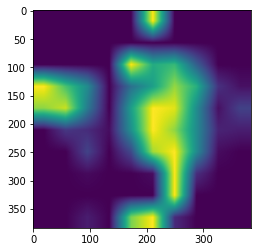

In [200]:
heatmap_actmap = cv2.resize(normalize(actmap_each.numpy()), (384, 384))
#heatmap_actmap = np.uint8(255 * heatmap_actmap)
#heatmap_actmap = cv2.applyColorMap(heatmap_actmap, cv2.COLORMAP_JET)
#heatmap_actmap = cv2.cvtColor(heatmap_actmap, cv2.COLOR_BGR2RGB)
plt.imshow(heatmap_actmap)

In [201]:
minval = np.min(heatmap_actmap)
maxval = np.max(heatmap_actmap)
heatmap_actmap = (heatmap_actmap-minval)/(maxval-minval)

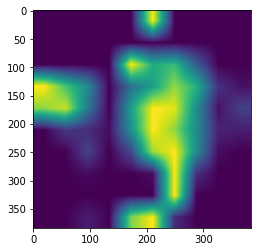

In [202]:
plt.imshow(heatmap_actmap)

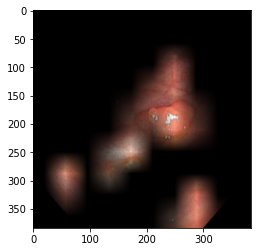

In [198]:
superimposed_img = (np.expand_dims(heatmap_actmap, axis=2) *  X_tst_s[img_num]).astype('uint8')
plt.imshow(superimposed_img)

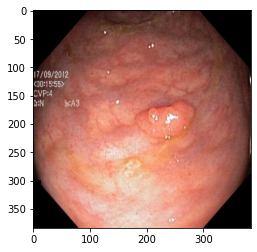

In [162]:
plt.imshow(X_tst_s[img_num])

In [10]:
cam = CAM_based_method(model, model_id, method = 'gradcam', img_dim=image_dim)

In [11]:
total = cam.total_auroc(X_tst_s_preprocessed, Y_tst_s)

In [12]:
total[0]

0.3528532019657662

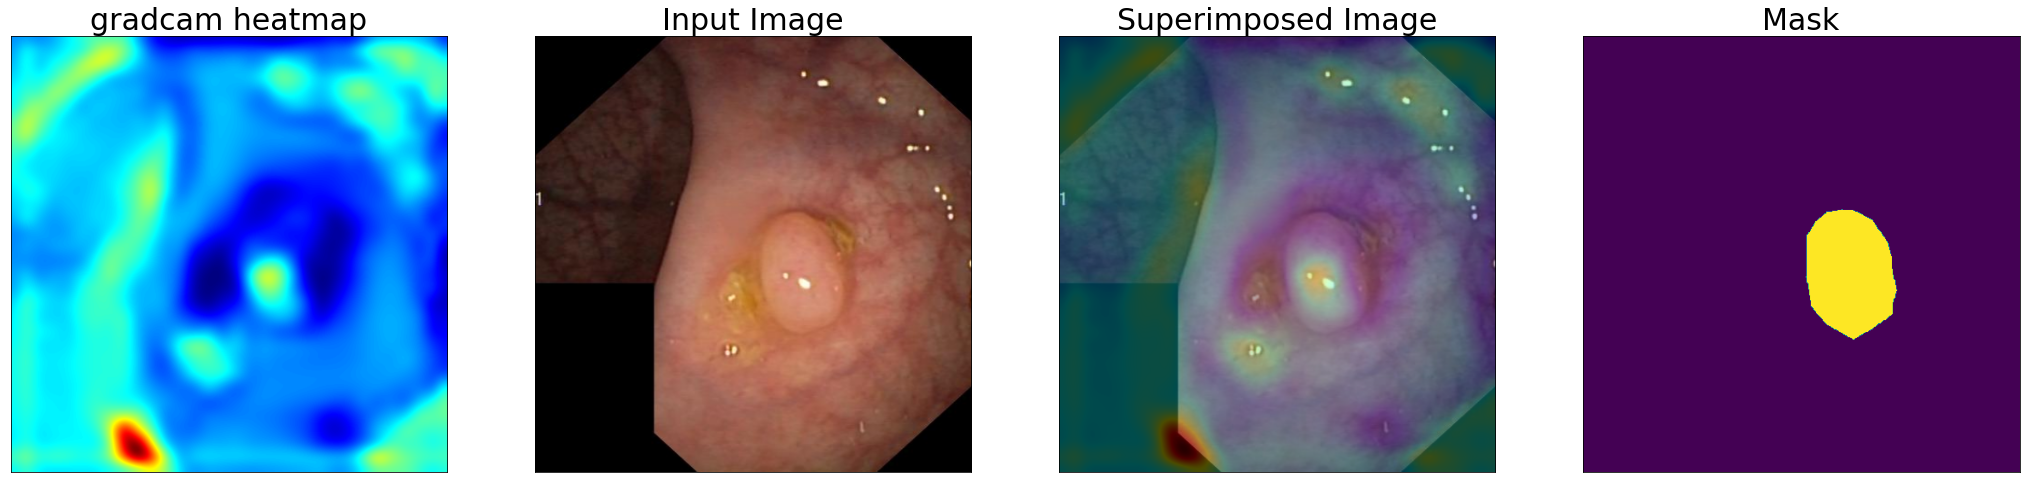

In [13]:
b=cam.visualize(X_tst_s_preprocessed[13], Y_tst_s[13], alpha=0.3)

In [105]:
a = np.argsort(total[1])

In [106]:
a

array([116, 145, 107,  41,  39,  20,  25, 131, 115,  91,  69,  14, 112,
       133,  55,  59,  30,  80,  21, 141,  40,  97, 117, 148, 127,  65,
        29,  94, 134, 103,  47, 146,  95,  96,  53,  44,  50,  52,  82,
       149,  57, 114, 118,   7, 138, 142, 135, 137, 128, 120,  73,  16,
        93, 136,  36,  54, 144,  61, 125,   0,  81,  63, 130,  26,  60,
       108,  37, 113,  10, 140,  42,  74,   4,  35,  33,   5,  98, 124,
       100,  28, 106, 129,   6,  56, 147, 139,  99,  77,  92,  68, 143,
        24,  12,  87,  83,   2,  23,  66,  67,  19,  46,  64,  32,  11,
        76,  31, 121,   3,  34, 126, 111, 119,  43,  79,  45,  62,   9,
        71,  85,  38,  86,  89,  22,  78,  15, 110,  72,  90,  84,  58,
       102,   1, 105, 109,  27,  48,  70,  18, 104, 123,  49, 101,  75,
        88,   8,  13,  51, 132,  17, 122], dtype=int64)

In [79]:
pred = model.predict(X_tst_s_preprocessed, batch_size = 2)
Y_tst_int = enc.inverse_transform(pred).ravel()

In [80]:
np.where(Y_tst_int!=7)

(array([  1,  25,  26,  41,  51,  97, 120, 122, 139, 142], dtype=int64),)

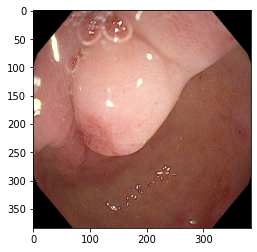

In [65]:
plt.imshow(X_tst_s[1])

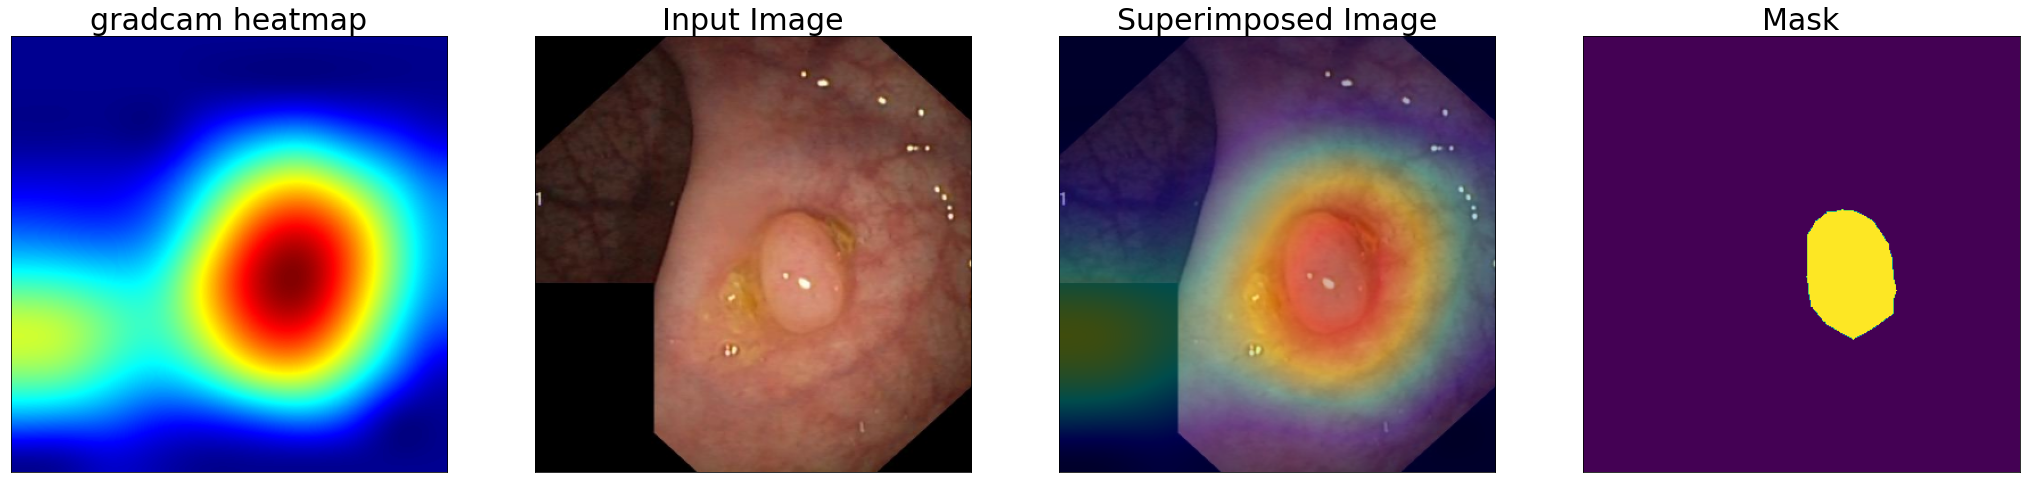

In [125]:
b=cam.visualize(X_tst_s_preprocessed[13], Y_tst_s[13], alpha=0.3)

In [107]:
13  17 132

SyntaxError: invalid syntax (<ipython-input-107-0595512f801c>, line 1)

In [ ]:
25,26, 41 

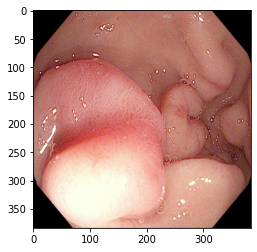

In [13]:
plt.imshow(X_tst_s[41])

In [8]:
pred = model.predict(X_tst_s_preprocessed, batch_size = 2)

In [14]:
pred[41]

array([7.1661416e-05, 9.6902520e-05, 4.7722383e-06, 1.2331903e-05,
       9.8954368e-01, 4.7692130e-04, 5.8243808e-07, 9.7931288e-03],
      dtype=float32)

In [18]:
a = open('pred_result.csv', 'w', newline='')
writer = csv.writer(a)
writer.writerow(pred[41])
a.close()

In [100]:
a=tf.nn.softmax(pred[17])

In [45]:
a

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([8.1059767e-07, 2.2647348e-03, 3.0656211e-06, 2.2289366e-06,
       2.9707692e-06, 1.2123594e-06, 4.0743998e-08, 9.9772495e-01],
      dtype=float32)>

In [50]:
np.set_printoptions(precision=4)
a.numpy()

array([8.1060e-07, 2.2647e-03, 3.0656e-06, 2.2289e-06, 2.9708e-06,
       1.2124e-06, 4.0744e-08, 9.9772e-01], dtype=float32)

In [ ]:
1,  25,  26,  41,  51,  97, 120, 122, 139, 142

In [ ]:
116 145 107

In [ ]:
13  17 132

In [ ]:
25,26, 41 

In [242]:
cam = CAM_based_method(model, model_id, method = 'gradcam++')

In [243]:
vis_num = 26

In [244]:
cam.single_auroc(X_tst_s_preprocessed[vis_num], Y_tst_s[vis_num])

0.8046702077533018

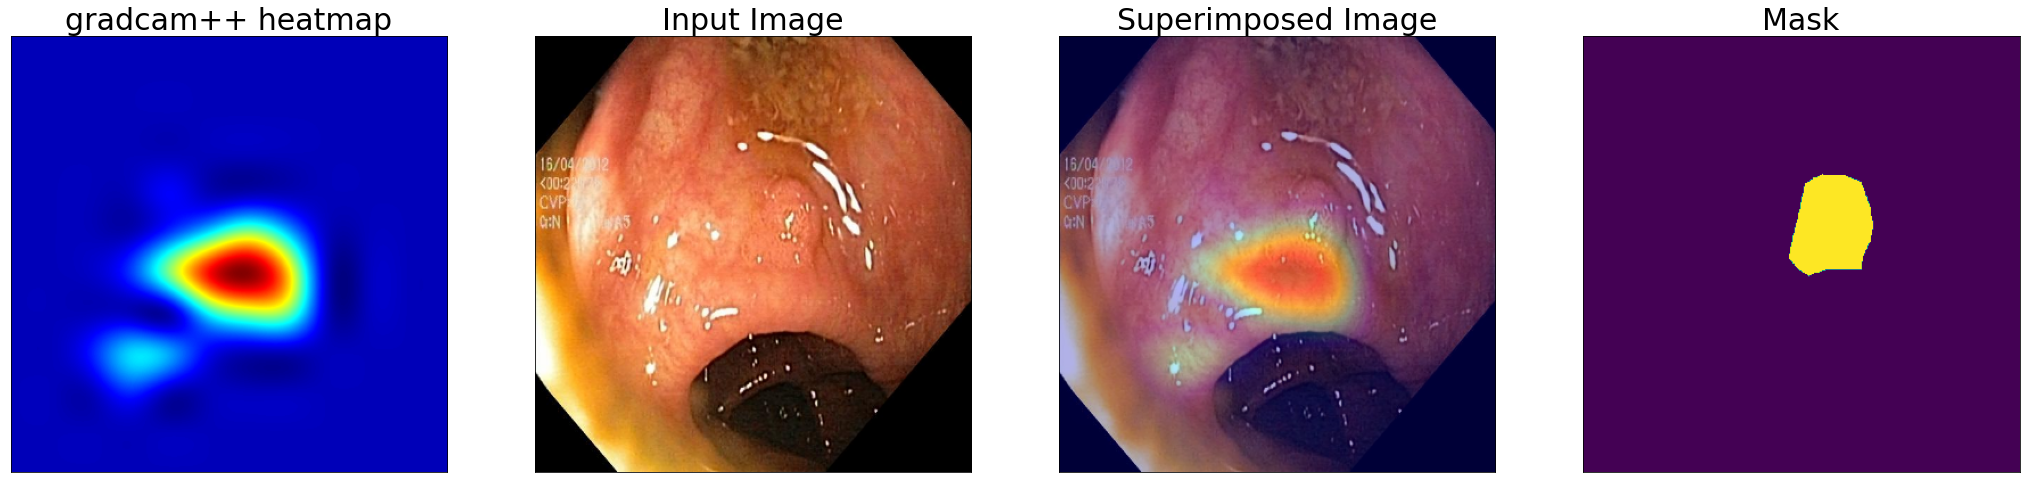

In [245]:
b=cam.visualize(X_tst_s_preprocessed[vis_num], Y_tst_s[vis_num], alpha=0.3)

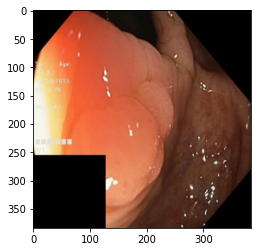

In [91]:
i=-1
plt.imshow(X_tst_s[i])

In [8]:
xai_list = ['gradcam', 'gradcam++', 'scorecam']

In [28]:
gradcam_auroc = []
gradcampp_auroc = []
scorecam_auroc = []
model_id =3

for seed in range(5):
    if model_id == 0:
        model = load_model('D:/kvasir_cls/models/' + 'kvasir_cls_' + model_list[model_id]+'_'+str(seed)+ '.h5')
        preprocess_func = VGG19_preprocess
        last_conv_layer_name = 'block5_conv4'
    elif model_id == 1:
        model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id]+'_'+str(seed)+ '.h5')
        preprocess_func = InceptionV3_preprocess
        last_conv_layer_name = 'mixed10'
    elif model_id == 2:
        model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id]+'_'+str(seed)+ '.h5')
        preprocess_func = ResNet50V2_preprocess
        last_conv_layer_name = 'conv5_block3_out'
    elif model_id == 3:
        model = load_model('D:/kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id]+'_'+str(seed)+ '.h5')
        preprocess_func = Xception_preprocess
        last_conv_layer_name = 'block14_sepconv2_act'
    X_tst_s_preprocessed = preprocess_func(X_tst_s)
    X_tst_preprocessed = preprocess_func(X_tst)
    for method in xai_list:
        cam = CAM_based_method(model, model_id, method = method)
        total = cam.total_auroc(X_tst_s_preprocessed, Y_tst_s)
        if method =='gradcam':
            gradcam_auroc.append(total)
        elif method =='gradcam++':
            gradcampp_auroc.append(total)
            
        elif method =='scorecam':
            scorecam_auroc.append(total)
        print('one cam-based method completed')    
    print('seed%d'%seed, 'completed')

one cam-based method completed
one cam-based method completed
one cam-based method completed
seed0 completed
one cam-based method completed
one cam-based method completed
one cam-based method completed
seed1 completed
one cam-based method completed
one cam-based method completed
one cam-based method completed
seed2 completed
one cam-based method completed
one cam-based method completed
one cam-based method completed
seed3 completed
one cam-based method completed
one cam-based method completed
one cam-based method completed
seed4 completed


In [22]:
scorecam_auroc[0][0]+

0.847531672974949

In [33]:
scorecam_auroc_real =[]
for auroc, _ in scorecam_auroc:
    scorecam_auroc_real.append(auroc)

In [34]:
print(np.mean(scorecam_auroc_real))
print(np.std(scorecam_auroc_real))

0.9015164649365384
0.007089665606070789
